In [21]:
import torch 
import numpy as np
from abc import ABC, abstractmethod 
import copy 

import sys
sys.path.insert(1,'./')
from HiCMap import HiCMap 

#### Outline of configuration classes

In [22]:
class Config(ABC):

    ########################################################
    # Properties 
    
    # The configuration itself
    @property
    @abstractmethod
    def values(self): 
        pass
    
    # Report the number of beads
    @property
    @abstractmethod
    def nBeads(self): 
        pass

    # Report device & dtype
    @property
    def dtype(self):
        return self.values.dtype

    @property
    def device(self):
        return self.values.device

    @property
    def shape(self):
        return self.values.shape
    
    ########################################################
    # Functionality 
    
    # Change the datatype & device types, etc., as in pytorch 
    def to(self,*args,**kwargs):
        return type(self)( self.values.to(*args,**kwargs) )

    # Allow coords object to be indexed directly
    @abstractmethod
    def subsetClass(self): # Initialize on 
        pass
        
    def __getitem__(self,i): 
        return type(self).subsetClass(self.values[i])

    def clone(self):
        return copy.deepcopy(self)

    @abstractmethod
    def append(self): 
        pass

    ########################################################
    # Converting between sample types 
    
    # Always be able to return coordinates object
    @abstractmethod
    def coordinates(self): 
        pass

    # Always be able to return distance maps 
    @abstractmethod
    def distances(self): 
        pass

#### Coordinate representation

In [23]:
def formatCoordinates(coords):

    dt = type(coords) 
    if dt != torch.Tensor: 
        try: 
            coords = torch.tensor(coords)
        except: 
            raise Exception(f'Passed coordinates must have be torch.Tensor or able to be converted to torch.Tensor object. Received type {dt}.')

    shape = coords.shape 
    coords = coords.squeeze() 
    assert len(coords.shape) == 2, f"Coordinate must have 2 non-singleton dimensions, but received shape {shape}."
    assert coords.shape[1] == 3, f"Expected final non-singleton dimension in coords to be size 3 (X,Y,Z). Received shape {shape}."
    
    return coords
    

In [24]:
class Coordinates(Config):
    '''
    Coordinates for a single configuration. 
    '''
    
    def __init__(self,coords):
        
        self.coords = formatCoordinates(coords)

    # Useful properties
    @property
    def values(self):
        return self.coords
    
    @property
    def nBeads(self):
        return self.coords.shape[0]

    def subsetClass(self):
        return Coordinates

    ########################################################
    # Methods
    def append(self):
        pass

    ########################################################
    # Converting between sample types

    # Should be 
    def coordinates(self): 
        return self.clone()
    
    def distances(self):
        return Distances(torch.cdist(self.coords,self.coords))
        

#### Distance Representation

In [25]:
class DistLoss(torch.nn.Module): 

    '''
    Loss function to use when correcting distance maps
    '''
    
    def __init__(self,dists,self_interaction_included=True):
        super().__init__()

        # ignore diagonal if it's self-interaction
        i,j = torch.triu_indices(dists.shape[-2],dists.shape[-1],
                                               int(self_interaction_included)) 
        self.dists = dists[...,i,j]#.squeeze()

        self.triu_indices = torch.triu_indices(
            dists.shape[-2]+1-int(self_interaction_included),
            dists.shape[-2]+1-int(self_interaction_included),
            1
        )

    def get_dists(self,coords):
        return torch.nn.functional.pdist(coords)
    
    def bond_strength(self):
        '''
        could add molecular interactions as well
        '''

    def forward(self,coords):
        i,j = self.triu_indices
        return (self.dists - torch.cdist(coords,coords)[...,i,j] ).abs().sum()

def adjustCoords(
    coords,
    dists,
    n_it=1000,
    lr=0.01,
    self_interaction_included=True
):
    '''
    Given an initial guess of coordinate locations and the
    distance map predicted by the diffusion model, adjust
    the coordinates to best match the predicted map. 
    '''

    distLoss = DistLoss(dists,self_interaction_included)

    coords.requires_grad_(True)

    optimizer = torch.optim.Adam([coords],lr=lr) 

    for _ in range(n_it):
        optimizer.zero_grad()
        loss = distLoss(coords)
        loss.backward()
        optimizer.step()
    
    return coords.detach()


def distToCoord(dists,correctCoords=True,*args,**kwargs):
    '''
    Assumes self interactions are INcluded in the map(s). 
    Supply a tensor

    args and kwargs are passed to adjustCoords (if correctCoords == True) 
    '''
    
    ##################################
    # Prepare for the computation
    
    # Check the input is valid 
    assert len(dists.shape) > 1, "The provided data must be of shape"
    s1,s2 = dists.shape[-2], dists.shape[-1]
    assert s1 == s2, f"The final two dimensions of tensors passed to distToCoord must be of the same size. Received sizes {s1} and {s2}."
    del s1, s2 

    # Use high precision here to minimize numerical issues, but return with the original data type (so remember initial data type). 
    # Note: PyTorch currently doesn't support higher than double, so use numpy 
    dtype,device = dists.dtype, dists.device
    dists = dists.cpu().numpy().astype(np.float128)
    #dists = dists.to(torch.double)
    
    # Initialize the coordinates object. 
    '''
    coords = torch.empty(
        *dists.shape[:-1],3,  # (optional dims)x(number of beads)x(3 (b/c Cartesian))
        dtype = torch.double,
        device = dists.device
    ).fill_(torch.nan) # nans just for testing purposes 
    '''
    coords = np.empty(
        (*dists.shape[:-1],3), # (optional dims)x(number of beads)x(3 (b/c Cartesian))
        dtype = np.float128
    )
    
    ##################################
    # Perform the computation 

    # Place bead 0 at the origin
    coords[...,0,:] = 0

    #### x coordinates 
    # Place bead 1 on the x axis
    coords[...,1,0] = dists[...,0,1]
    coords[...,1,1:] = 0

    # Get all other x coordinates 
    coords[...,2:,0] = ( 1 + (dists[...,0,2:]**2 - dists[...,1,2:]**2)/dists[...,0,1:2]**2 ) / 2

    #### y coordinates
    # Place bead 2 in the xy plane with positive y 
    #coords[...,2,1] = ( dists[...,0,1]**2 - coords[...,2,0]**2 ).sqrt()
    coords[...,2,1] = np.sqrt( dists[...,0,1]**2 - coords[...,2,0]**2 )
    coords[...,2,2] = 0 

    # Get other y coordinates
    coords[...,3:,1] = 1
    coords[...,3:,1]+= ( dists[...,0,3:]**2 - coords[...,3:,0]**2 - dists[...,2,3:]**2 + (coords[...,3:,0] - coords[...,2:3,0])**2 ) / (dists[...,0,2:3]**2 - coords[...,2:3,0]**2)
    coords[...,3:,1]/= 2

    #### z coordinates
    # Give bead 3 a positive z value 
    #coords[...,3,2] = ( dists[...,0,3]**2 - coords[...,3,:2].square().sum(-1) ).sqrt()
    coords[...,3,2] = np.sqrt( dists[...,0,3]**2 - (coords[...,3,:2]**2).sum(-1) )
    
    # Get other z coordinates
    coords[...,4:,2] = dists[...,0,4:]**2 - dists[...,3,4:]**2
    #coords[...,4:,2]+= (coords[...,4:,:2] - coords[...,3:4,:2]).square().sum(-1) - coords[...,4:,:2].square().sum(-1)
    coords[...,4:,2]+= ( (coords[...,4:,:2] - coords[...,3:4,:2])**2).sum(-1) - np.square(coords[...,4:,:2]**2).sum(-1)
    coords[...,4:,2]/= coords[...,3:4,2]**2
    coords[...,4:,2]+= 1
    coords[...,4:,2]/= 2

    coords = torch.from_numpy(coords.astype(np.float64)).to(device) 
    print(coords.isnan().sum())
    print(coords.numel())
    
    if correctCoords: 
        coords = adjustCoords(coords,dists)
    
    return coords.to(dtype) 

In [804]:
def largest_dist_idx(dists):
    return torch.where(dists==dists.max(-1,keepdim=True).values)[-1]

def project_via_distances(di,dij,r_j,dj=None):
    '''
    Get the projection of vector r_i onto r_j using known distance values. 
    
    di: Magnitude of r_i
    dj: Magnitude of r_j
    dij: Magnitude of (r_i - r_j) 
    r_j: Coordinate vector onto which r_i is being projected
    '''

    if dj is None: 
        dj = r_j.square().sum(-1).sqrt()
        
    proj = ((dij**2 - di**2)/dj**2 - 1).unsqueeze(-1).expand_as(r_j)
    return proj * r_j
    
    return ((dij**2 - di**2)/dj**2 - 1) * r_j

def project_via_dot(r_i,r_j,dj=None): 
    '''
    Typical projection algorithm. Project r_i onto r_j. 
    '''
    #r_j = r_j.unsqueeze(-2).expand_as(r_i) 
    r_j = r_j.expand_as(r_i)
    if dj is None: 
        dj = r_j.square().sum(-1,keepdim=True).expand_as(r_j)

    # Return (0,0,...,0) whenever the origin is passed.
    proj = torch.zeros_like(r_i) 
    idx = dj.expand_as(proj)!=0
    proj[idx] = ((r_j[idx]*r_i[idx]).sum(-1) / dj[idx]**2) * r_j[idx]
    #proj[idx,:] = ((r_j[idx,:]*r_i[idx,:]).sum(-1) / dj[idx]**2) * r_j[idx,:]

    return proj  

def get_coords_from_dists(dists,*anchor_coords):
    '''
    dists here should be size (optional dims, batch etc.)x(ndim+1)x(nbeads whose positions are computed based on distances from those ndim+1 coordinate-defining beads). 
    It contains the distance between the bead corresponding to that row and the other beads of interest. 

    There should be ndim anchor_coords arguments of size (optional dims, batch etc.)x(ndim+1). They should be provided in the order of coordinates of interest (e.g. x, y, z)
    anchor_coords should be size (optional dims, batch etc.)x(ndim+1)x(ndim). It contains the coordinates of dists, in the same order. 
    
    dim 0 in dists is treated as the origin, dim 1 as the 
    '''
    ndim = anchor_coords[0].shape[-1] 
    nbeads = dists.shape[-1] 
    coords = torch.zeros(*dists.shape[:-2],nbeads,ndim,device=dists.device,dtype=dists.dtype)

    origin = anchor_coords[0].unsqueeze(-2)
    origin = origin.expand(*origin.shape[:-2],nbeads,ndim)
    for i,anchor_coords in enumerate(anchor_coords[1:]):
        r_j = (anchor_coords[i+1] - origin).expand_as(origin)
        proj = project_via_distances(dists[...,0,:],dists[...,i+1,:],r_j) # Projection to vector
        proj-= project_via_dot(proj,coords)# Reduce to the orthogonal component
        print(f'coords: {coords.shape}')
        print(f'proj: {proj.shape}')
        coords+= proj

    coords+= origin 
    return coords 


def distToCoord(dists,correctCoords=True,ndim=3,*args,**kwargs):
    ''' At present, assumed ndim==3 
    Assumes self interactions are INcluded in the map(s). 
    Supply a tensor

    args and kwargs are passed to adjustCoords (if correctCoords == True) 
    '''
    ##################################
    # Prepare for the computation
    
    # Check the input is valid 
    assert len(dists.shape) > 1, "The provided data must be of shape"
    s1,s2 = dists.shape[-2], dists.shape[-1]
    assert s1 == s2, f"The final two dimensions of tensors passed to distToCoord must be of the same size. Received sizes {s1} and {s2}."
    del s1, s2 

    # Use high precision here to minimize numerical issues, but return with the original data type (so remember initial data type). 
    # Note: PyTorch currently doesn't support higher than double, so use numpy 
    dtype,device = dists.dtype, dists.device
    #dists = dists.cpu().numpy().astype(np.float128)
    dists = dists.to(torch.double)
    
    # Initialize the coordinates object. 
    
    coords = torch.zeros(
        *dists.shape[:-1],ndim,  # (optional dims)x(number of beads)x(3 (b/c Cartesian))
        dtype = torch.double,
        device = dists.device
    )#.fill_(torch.nan) # nans just for testing purposes 

    ##################################
    # Computation

    # Keep track of which beads still need to have their coordinates computed
    beads_to_consider = torch.ones(*dists.shape[:-1],device=device,dtype=bool)
    
    ###
    # Choose four beads to use as the basis for computing all x,y,z positions.
    
    # Place bead 0 at the origin.
    '''
    coords[...,0,:] = 0 
    beads_to_consider[...,0] = False
    remaining_dist_square = dists[...,0,:].square() 

    # Then, choose the point furthest away as possible and place that on the +x axis. 
    # This minimizes numerical error later. 
    

    # Do the same for y, z, etc. coordinates. 
    # Place bead 1 on the x axis
    bead1 = remaining_dist_square
    
    coords[...,1,0] = dists[...,0,1]
    coords[...,1,1:] = 0

    # Get all other x coordinates 
    coords[...,2:,0] = ( 1 + (dists[...,0,2:]**2 - dists[...,1,2:]**2)/dists[...,0,1:2]**2 ) / 2

    #### y coordinates
    # Place bead 2 in the xy plane with positive y 
    #coords[...,2,1] = ( dists[...,0,1]**2 - coords[...,2,0]**2 ).sqrt()
    coords[...,2,1] = np.sqrt( dists[...,0,1]**2 - coords[...,2,0]**2 )
    coords[...,2,2] = 0 

    # Get other y coordinates
    coords[...,3:,1] = 1
    coords[...,3:,1]+= ( dists[...,0,3:]**2 - coords[...,3:,0]**2 - dists[...,2,3:]**2 + (coords[...,3:,0] - coords[...,2:3,0])**2 ) / (dists[...,0,2:3]**2 - coords[...,2:3,0]**2)
    coords[...,3:,1]/= 2

    #### z coordinates
    # Give bead 3 a positive z value 
    #coords[...,3,2] = ( dists[...,0,3]**2 - coords[...,3,:2].square().sum(-1) ).sqrt()
    coords[...,3,2] = np.sqrt( dists[...,0,3]**2 - (coords[...,3,:2]**2).sum(-1) )
    '''
    print(f'Coords: {coords.shape}')
    remaining_dist_square = dists[...,0,:]**2
    bead_choices = [torch.zeros_like(coords[...,:1,0],dtype=int)]
    anchor_coords = [coords[...,0,:]]
    for i in range(ndim): ############################
        bead_choices.append( largest_dist_idx(remaining_dist_square).unsqueeze(-1) )

        # Set the remaining component squarely on the relevant axis for the component chosen to lie
        # on that axis 
        coords[...,i].scatter_(
            -1,
            bead_choices[-1],
            remaining_dist_square.gather(-1,bead_choices[-1]).sqrt()
        )
        anchor_coords.append(
            coords.gather(
                -2,
                bead_choices[-1].expand_as(anchor_coords[0]).unsqueeze(-2)
            )[...,0,:]
        )
        beads_to_consider.scatter_(-1,bead_choices[-1],0)

        # Update remaining_dist_square
        #print(f'cat shape: {torch.cat([dists.gather(-2,bc.unsqueeze(-1)) for bc in bead_choices],dim=-1).shape}')
        #print(f'Stack shape: {torch.stack(anchor_coords,-1).shape}')
        #print(torch.cat([dists.gather(-2,bc.unsqueeze(-1)) for bc in bead_choices],dim=-1).shape)
        #print(torch.stack(anchor_coords,-1).shape)

        print(f'dists: {torch.cat([dists.gather(-2,bc.unsqueeze(-2)) for bc in bead_choices],dim=-2).shape}')
        temp_coords = get_coords_from_dists(
            torch.cat([dists.gather(-2,bc.unsqueeze(-2)).expand_as(dists[...,:1,:]) for bc in bead_choices],dim=-2),
            *anchor_coords
        )
        print(f'temp coords: {temp_coords.shape}')
        print(f'NaN any: {temp_coords.isnan().any()}')
        print(f'NaN all: {temp_coords.isnan().all()}')
        
        # Update the other coordinates
        remaining_dist_square = dists[...,0,:]**2 - temp_coords.square().sum(-1) 
        #print(dists.shape)
        #print(beads_to_consider.shape)
        #print(f'gather: {(dists[...,0,:].gather(-1,torch.where(beads_to_consider)[-1].reshape(*dists.shape[:-2],dists.shape[-1]-i-1))**2).shape}')
        #remaining_dist_square = dists[...,0,:].gather(-1,torch.where(beads_to_consider)[-1])**2 - temp_coords.square().sum(-1) 
        #remaining_dist_square = dists[...,0,:].gather(-1,torch.where(beads_to_consider)[-1].
        #                                              reshape(*dists.shape[:-2],dists.shape[-1]-i-1))**2) -\ temp_coords.square().sum(-1)

        
        '''
        di = dists[...,0,:][beads_to_consider]
        dj = dists.gather(-1,bead_choices[-1].unsqueeze(-1))[...,0]
        dij = dj[beads_to_consider] 
        dj = dj.gather(-1,beads_to_consider[-1])[...,0] 
        
        
        dj = dists[...,0,:].gather(-1,bead_choices[-1])
        dij = dists.gather(-1,bead_choices[-1].unsqueeze(-1)).gather(-2,beads_to_consider)[...,0,0]
        #di = [dists.gather(-1,bc.unsqueeze(1))[...,0] for bc in bead_choices]
        new_proj = project_via_distances(di,dij,r_j,dj=None)
        
        coords[...,beads_to_consider,:i+1] = get_coords_from_dists(
            dists[...,],
            *anchor_coords
        )
        
        coords_temp = get_coords_from_dists(dists,*anchor_coords):
        
        remaining_dist_square.scatter_(
            -1,
            bead_choices[-1],
            torch.zeros_like(remaining_dist_square[...,:1])
        )

        # Determine how much of each remaining vector resides in orthogonal directions
        coords
        remaining_dist_square = dists[...,0,:]**2 - 
        
        
        beads_to_consider
        bead_choices

        # 

        coords[bead_choices[-1],:] = remaining_dist_square[bead_choices[-1]]

        di = dists[]
        coords[bead_choices[-1],:] = project_via_distances(coords)
        coords[bead_choices[-1],:] = remaining_dist_square[bead_choices[-1]].sqrt()
        remaining_dist_square-= dists[bead_choices[-1],beads_to_consider]**2
        '''
    # Now get the distances
    #coords = get_coords_from_dists(
    #    torch.cat([dists.gather(-2,bc.unsqueeze(-1)) for bc in bead_choices],dim=-1),
    #    *anchor_coords
    #)
    coords = get_coords_from_dists(
        torch.cat([dists.gather(-2,bc.unsqueeze(-2)).expand_as(dists[...,:1,:]) for bc in bead_choices],dim=-2),
        *anchor_coords
    )

    return coords
    


In [805]:
ii = torch.ones(10,1,3,dtype=int)
sample.gather(-2,ii).shape

torch.Size([10, 1, 3])

In [806]:
a = torch.rand(10,10,10)
a.gather(-2,torch.ones_like(a[...,:1],dtype=int)).shape

torch.Size([10, 10, 1])

In [807]:
import torch

In [808]:
def generateSample(nbeads,nsamples=1,bond_length=1): 

    coords = torch.empty(nsamples,nbeads,3)
    coords[:,0,:] = 0 # Bead 0 at origin 
    for i in range(1,nbeads): 
        step = torch.randn(nsamples,3)
        step/= (step.square().sum(-1,keepdim=True).sqrt() * bond_length).expand(-1,3) 
        coords[:,i,:] = coords[:,i-1,:] + step

    return coords
        

In [809]:
sample = generateSample(100,10)

In [810]:
dists = torch.cdist(sample,sample)

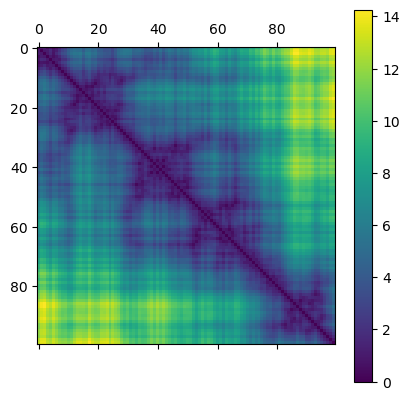

In [811]:
import matplotlib.pyplot as plt
plt.matshow(dists[0,...].numpy())
plt.colorbar()

In [812]:
coords2 = distToCoord(dists,False)

Coords: torch.Size([10, 100, 3])
dists: torch.Size([10, 2, 1])
coords: torch.Size([10, 100, 3])
proj: torch.Size([10, 100, 3])
temp coords: torch.Size([10, 100, 3])
NaN any: False
NaN all: False
dists: torch.Size([10, 3, 1])
coords: torch.Size([10, 100, 3])
proj: torch.Size([10, 100, 3])
coords: torch.Size([10, 100, 3])
proj: torch.Size([10, 100, 3])
temp coords: torch.Size([10, 100, 3])
NaN any: True
NaN all: True


RuntimeError: The expanded size of the tensor (10) must match the existing size (0) at non-singleton dimension 0.  Target sizes: [10, 3].  Tensor sizes: [0, 1]

In [792]:
real_idx = coords2.isfinite().all(-1).all(-1)

dist1 = dists[real_idx,...]

dist2 = torch.cdist(coords2[real_idx,...],coords2[real_idx,...]) 

In [793]:
import matplotlib.pyplot as plt
i = 0
plt.matshow(dist1[i,...].numpy())
plt.colorbar()
plt.matshow(dist2[i,...].numpy())
plt.colorbar()

IndexError: index 0 is out of bounds for dimension 0 with size 0

In [794]:
coords2.isnan().all()

tensor(True)

In [82]:
dists.shape

torch.Size([10, 100, 100])

In [49]:
class Distances(Config):
    '''
    Distance map for a single configuration. 
    '''
    
    def __init__(self,coords,dtype=None,device=None):
        
        self.distMap = toCoordinates(coords).to(dtype=dtype,device=device)

    # Useful properties
    @property
    def values(self):
        return self.coords
    
    @property
    def nBeads(self):
        return self.coords.shape[0]

    ########################################################
    # Converting between sample types

    # Should be 
    def coordinates(self): 
        return distToCoord(self.)
    
    def distances(self):
        return Distances(torch.cdist(self.coords,self.coords))
    
    

In [69]:
a = torch.rand(10,10)
a = a.fill_(torch.nan) 
a

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]])

In [62]:
a = Coordinates(torch.rand(10,3))
a.to(torch.double).dtype

torch.float64

In [64]:
a.values

tensor([[0.9606, 0.6966, 0.2798],
        [0.9629, 0.4943, 0.0981],
        [0.7420, 0.7462, 0.7877],
        [0.8338, 0.8183, 0.0305],
        [0.9183, 0.2176, 0.1432],
        [0.6269, 0.5522, 0.7841],
        [0.5732, 0.8605, 0.2021],
        [0.5572, 0.8367, 0.1835],
        [0.2326, 0.4193, 0.3688],
        [0.6505, 0.8276, 0.5826]])

In [5]:
torch.tensor([[1,2,3],[4,5,6]])

tensor([[1, 2, 3],
        [4, 5, 6]])

In [6]:
a = np.ones((4,4))

In [7]:
torch.tensor(a)

tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]], dtype=torch.float64)

In [34]:
class Test: 

    def __init__(self,i):
        self.i = i

In [39]:
t = Test(10)
tt = type(t)(t.i) 
tt

In [40]:
tt.i

10